# Imports

In [60]:
import collections

import numpy as np
import torch

import extract
from utils_extraction.classifier import (
    train_ccs_lr,
    make_contrast_pair_data,
    fit_ccs_lr,
)
from utils_extraction.load_utils import (
    load_hidden_states_for_datasets,
    make_permutation_dict,
)
from utils.plotting import plot_accuracy, plot_history
from utils_extraction.projection import IdentityReduction
from utils_generation import hf_utils
from utils_generation.hf_auth_token import HF_AUTH_TOKEN

# Config

In [61]:
_config = dict(
    model="meta-llama/Llama-2-7b-chat-hf",
    datasets=["imdb"],
    labeled_datasets=["copa"],
    eval_datasets=["imdb", "copa"],
    prefix="normal-bananashed",
    test_prefix="normal-bananashed",
    method_list=["pseudolabel"],
    mode="concat",
    load_dir="generation_results",
    location="auto",
    layer=-1,
)
_config["num_layers"] = hf_utils.get_num_hidden_layers(
    _config["model"], use_auth_token=HF_AUTH_TOKEN
)


_config = extract._format_config(_config)
train_datasets = _config["datasets"]
labeled_train_datasets = _config["labeled_datasets"]
eval_datasets = _config["eval_datasets"]
prefix = _config["prefix"]
test_prefix = _config["test_prefix"] if _config["test_prefix"] is not None else prefix
model = _config["model"]

pseudo_label_config = dict(
    n_rounds=10,
    select_fn="high_confidence_consistency",
    prob_threshold=0.8,
    label_fn="argmax",
)

# Data utils

In [62]:
def get_data(_config):
    train_datasets = _config["datasets"]
    labeled_train_datasets = _config["labeled_datasets"]
    eval_datasets = _config["eval_datasets"]
    prefix = _config["prefix"]
    test_prefix = (
        _config["test_prefix"] if _config["test_prefix"] is not None else prefix
    )
    model = _config["model"]

    data_dict = None
    eval_results = collections.defaultdict(list)

    # Generate data.
    datasets_to_load = list(
        set(train_datasets + labeled_train_datasets + eval_datasets)
    )
    prefixes = set([prefix, test_prefix])
    data_dict = {}
    for prefix_ in prefixes:
        # Only generate the data (and other related dictionaries) once to keep
        # them the same across methods.
        prefix_data_dict = load_hidden_states_for_datasets(
            _config["load_dir"],
            mdl_name=model,
            dataset_list=datasets_to_load,
            prefix=prefix_,
            location=_config["location"],
            layer=_config["layer"],
            mode="concat",
        )
        data_dict[prefix_] = prefix_data_dict

    permutation_dict = {
        ds: make_permutation_dict(data_dict[prefix][ds]) for ds in datasets_to_load
    }
    projection_datasets = set(train_datasets + labeled_train_datasets)
    # Arbitrarily use prefix instead of test_prefix to index into data_dict
    # since the number of prompts should be the same for both.
    projection_dict = {
        ds: list(range(len(data_dict[prefix][ds]))) for ds in projection_datasets
    }

    unlabeled_train_data_dict = {
        ds: range(len(data_dict[prefix][ds])) for ds in train_datasets
    }
    labeled_train_data_dict = {
        ds: range(len(data_dict[prefix][ds])) for ds in labeled_train_datasets
    }

    test_dict = {ds: range(len(data_dict[test_prefix][ds])) for ds in eval_datasets}

    return (
        data_dict,
        permutation_dict,
        projection_dict,
        unlabeled_train_data_dict,
        labeled_train_data_dict,
        test_dict,
    )

# Pseudo-label

In [74]:
def make_pseudolabel_mask(
    config, train_p0: np.ndarray, train_p1: np.ndarray
) -> np.ndarray:
    select_fn = config["select_fn"]
    if select_fn == "high_confidence_consistency":
        return make_high_confidence_consistency_mask(config, train_p0, train_p1)
    else:
        raise ValueError(f"Invalid select_fn: {select_fn}")


def make_high_confidence_consistency_mask(
    config, train_p0: np.ndarray, train_p1: np.ndarray
) -> np.ndarray:
    prob_threshold = config["prob_threshold"]
    x0_prob_high_mask = train_p0 >= prob_threshold
    x1_prob_high_mask = train_p1 >= prob_threshold
    return np.logical_xor(x0_prob_high_mask, x1_prob_high_mask)


def make_pseudolabels(config, train_p0: np.ndarray, train_p1: np.ndarray):
    label_fn = config["label_fn"]
    if label_fn == "argmax":
        return argmax_pseudolabels(config, train_p0, train_p1)
    else:
        raise ValueError(f"Invalid label_fn: {label_fn}")


def argmax_pseudolabels(config, train_p0: np.ndarray, train_p1: np.ndarray):
    return np.argmax(np.stack([train_p0, train_p1], axis=1), axis=1)

In [111]:
def train_pseudo_label(
    data_dict,
    labeled_train_data_dict,
    unlabeled_train_data_dict,
    permutation_dict,
    labeled_prefix: str,
    unlabeled_prefix: str,
    pseudo_label_config,
    project_along_mean_diff: bool = False,
    projection_model=None,
    train_kwargs=None,
    device="cuda",
    logger=None,
):
    projection_model = projection_model or IdentityReduction()

    # Labeled data.
    (train_sup_x0, train_sup_x1), train_sup_y = make_contrast_pair_data(
        target_dict=labeled_train_data_dict,
        data_dict=data_dict[labeled_prefix],
        permutation_dict=permutation_dict,
        projection_model=projection_model,
        split="train",
        project_along_mean_diff=project_along_mean_diff,
    )
    (test_sup_x0, test_sup_x1), test_sup_y = make_contrast_pair_data(
        target_dict=labeled_train_data_dict,
        data_dict=data_dict[labeled_prefix],
        permutation_dict=permutation_dict,
        projection_model=projection_model,
        split="test",
        project_along_mean_diff=project_along_mean_diff,
    )
    # Unlabeled data.
    (train_unsup_x0, train_unsup_x1), train_unsup_y = make_contrast_pair_data(
        target_dict=unlabeled_train_data_dict,
        data_dict=data_dict[unlabeled_prefix],
        permutation_dict=permutation_dict,
        projection_model=projection_model,
        split="train",
        project_along_mean_diff=project_along_mean_diff,
    )
    (test_unsup_x0, test_unsup_x1), test_unsup_y = make_contrast_pair_data(
        target_dict=unlabeled_train_data_dict,
        data_dict=data_dict[unlabeled_prefix],
        permutation_dict=permutation_dict,
        projection_model=projection_model,
        split="test",
        project_along_mean_diff=project_along_mean_diff,
    )

    train_kwargs = train_kwargs or {}
    fit_result = fit_ccs_lr(
        train_sup_x0,
        train_sup_x1,
        train_sup_y,
        train_unsup_x0,
        train_unsup_x1,
        train_unsup_y,
        test_sup_x0,
        test_sup_x1,
        test_sup_y,
        test_unsup_x0,
        test_unsup_x1,
        test_unsup_y,
        verbose=True,
        device=device,
        logger=logger,
        **train_kwargs,
    )
    fit_results = [fit_result]
    probes = [fit_result["best_probe"]]

    n_rounds = pseudo_label_config["n_rounds"]
    cur_probe = probes[0]

    for i in range(n_rounds):
        if logger is not None:
            logger.info(f"Round {i + 1}/{n_rounds}")
        else:
            print(f"Round {i + 1}/{n_rounds}")

        train_unsup_acc, train_unsup_p0, train_unsup_p1, train_unsup_probs = (
            cur_probe.evaluate_accuracy(
                torch.tensor(train_unsup_x0, dtype=torch.float32, device=device),
                torch.tensor(train_unsup_x1, dtype=torch.float32, device=device),
                torch.tensor(train_unsup_y, dtype=torch.float32, device=device),
            )
        )
        train_unsup_p0 = train_unsup_p0.cpu().numpy()
        train_unsup_p1 = train_unsup_p1.cpu().numpy()
        # Accuracy is unused because we assume to not have the true labels.
        del train_unsup_acc

        # Select probabilities for pseudo-labeling.
        pseudolabel_mask = make_pseudolabel_mask(
            pseudo_label_config, train_unsup_p0, train_unsup_p1
        )
        assert (
            pseudolabel_mask.ndim == 2 and pseudolabel_mask.shape[1] == 1
        ), pseudolabel_mask.shape
        train_unsup_p0_with_pseudolabels = train_unsup_p0[pseudolabel_mask]
        train_unsup_p1_with_pseudolabels = train_unsup_p1[pseudolabel_mask]

        # Make pseudo-labels.
        train_unsup_pseudolabels = make_pseudolabels(
            pseudo_label_config,
            train_unsup_p0_with_pseudolabels,
            train_unsup_p1_with_pseudolabels,
        )

        # Get pseudo-labeled x data.
        n_pairs_with_pseudolabels = pseudolabel_mask.sum()
        broadcast_pseudolabel_mask = np.broadcast_to(
            pseudolabel_mask, train_unsup_x0.shape
        )
        train_unsup_x0_with_pseudolabels = train_unsup_x0[
            broadcast_pseudolabel_mask
        ].reshape((n_pairs_with_pseudolabels, -1))
        train_unsup_x1_with_pseudolabels = train_unsup_x1[
            broadcast_pseudolabel_mask
        ].reshape((n_pairs_with_pseudolabels, -1))

        # Concatenate original labeled data with the pseudo-labeled data.
        train_sup_x0 = np.concatenate(
            [train_sup_x0, train_unsup_x0_with_pseudolabels], axis=0
        )
        train_sup_x1 = np.concatenate(
            [train_sup_x1, train_unsup_x1_with_pseudolabels], axis=0
        )
        train_sup_y = np.concatenate([train_sup_y, train_unsup_pseudolabels], axis=0)

        # Update unlabeled data to be the remaining un-pseudo-labeled data.
        # This is the unlabeled data on which the accuracy is evaluated on this
        # round.
        n_pairs_without_pseudolabels = len(pseudolabel_mask) - n_pairs_with_pseudolabels
        train_unsup_x0 = train_unsup_x0[~broadcast_pseudolabel_mask].reshape(
            (n_pairs_without_pseudolabels, -1)
        )
        train_unsup_x1 = train_unsup_x1[~broadcast_pseudolabel_mask].reshape(
            (n_pairs_without_pseudolabels, -1)
        )
        train_unsup_y = train_unsup_y[~pseudolabel_mask.squeeze(1)]

        # Fit the model to the pseudo-labeled data and original labeled data.
        fit_result_with_pseudolabels = fit_ccs_lr(
            train_sup_x0,
            train_sup_x1,
            train_sup_y,
            train_unsup_x0,  # Only for eval, not for training.
            train_unsup_x1,  # Only for eval, not for training.
            train_unsup_y,  # Only for eval, not for training.
            test_sup_x0,
            test_sup_x1,
            test_sup_y,
            test_unsup_x0,
            test_unsup_x1,
            test_unsup_y,
            verbose=True,
            device=device,
            logger=logger,
            **train_kwargs,
        )
        cur_probe = fit_result_with_pseudolabels["best_probe"]
        fit_results.append(fit_result_with_pseudolabels)
        probes.append(cur_probe)

    return probes, fit_results

In [110]:
np.arange(3)[:, None][[0, 2]].shape

(2, 1)

# Load data

In [76]:
_config = dict(
    model="meta-llama/Llama-2-7b-chat-hf",
    datasets=["imdb"],
    labeled_datasets=["dbpedia-14"],
    eval_datasets=["imdb", "dbpedia-14"],
    prefix="normal-bananashed",
    test_prefix="normal-bananashed",
    method_list=["pseudolabel"],
    mode="concat",
    load_dir="generation_results",
    location="auto",
    layer=-1,
)
_config["num_layers"] = hf_utils.get_num_hidden_layers(
    _config["model"], use_auth_token=HF_AUTH_TOKEN
)


_config = extract._format_config(_config)
train_datasets = _config["datasets"]
labeled_train_datasets = _config["labeled_datasets"]
eval_datasets = _config["eval_datasets"]
prefix = _config["prefix"]
test_prefix = _config["test_prefix"] if _config["test_prefix"] is not None else prefix
model = _config["model"]

(
    data_dict,
    permutation_dict,
    projection_dict,
    unlabeled_train_data_dict,
    labeled_train_data_dict,
    test_dict,
) = get_data(_config)

del test_dict  # Unused

/nas/ucb/ebronstein/anaconda3/envs/exhaustive-ccs/lib/python3.9/site-packages/transformers/models/auto/configuration_auto.py:1085: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


# Run train

In [115]:
pseudo_label_config = dict(
    n_rounds=5,
    select_fn="high_confidence_consistency",
    prob_threshold=0.8,
    label_fn="argmax",
)

unlabeled_prefix = test_prefix
train_kwargs = dict(n_tries=1, n_epochs=5000, lr=1e-2, unsup_weight=0.0, sup_weight=1.0)
device = "cuda" if torch.cuda.is_available() else "cpu"
probes, fit_results = train_pseudo_label(
    data_dict,
    labeled_train_data_dict,
    unlabeled_train_data_dict,
    permutation_dict,
    labeled_prefix=_config["prefix"],
    unlabeled_prefix=_config["test_prefix"],
    pseudo_label_config=pseudo_label_config,
    train_kwargs=train_kwargs,
    device=device,
)

Epoch 100/5000, Loss: 1.8243162631988525
Epoch 200/5000, Loss: 1.618649959564209
Epoch 300/5000, Loss: 1.472893476486206
Epoch 400/5000, Loss: 1.35514235496521
Epoch 500/5000, Loss: 1.2567615509033203
Epoch 600/5000, Loss: 1.1732845306396484
Epoch 700/5000, Loss: 1.1018511056900024
Epoch 800/5000, Loss: 1.040340542793274
Epoch 900/5000, Loss: 0.9869792461395264
Epoch 1000/5000, Loss: 0.9402530193328857
Epoch 1100/5000, Loss: 0.8989261388778687
Epoch 1200/5000, Loss: 0.8620333075523376
Epoch 1300/5000, Loss: 0.8288300037384033
Epoch 1400/5000, Loss: 0.7987387180328369
Epoch 1500/5000, Loss: 0.7713033556938171
Epoch 1600/5000, Loss: 0.7461574077606201
Epoch 1700/5000, Loss: 0.72300124168396
Epoch 1800/5000, Loss: 0.7015868425369263
Epoch 1900/5000, Loss: 0.6817070841789246
Epoch 2000/5000, Loss: 0.6631875038146973
Epoch 2100/5000, Loss: 0.6458802223205566
Epoch 2200/5000, Loss: 0.6296589374542236
Epoch 2300/5000, Loss: 0.6144139766693115
Epoch 2400/5000, Loss: 0.6000511646270752
Epoch 25

# Run eval

In [122]:
labeled_prefix = _config["prefix"]
unlabeled_prefix = _config["test_prefix"]
projection_model = IdentityReduction()
project_along_mean_diff = False

# Labeled data.
(train_sup_x0, train_sup_x1), train_sup_y = make_contrast_pair_data(
    target_dict=labeled_train_data_dict,
    data_dict=data_dict[labeled_prefix],
    permutation_dict=permutation_dict,
    projection_model=projection_model,
    split="train",
    project_along_mean_diff=project_along_mean_diff,
)
(test_sup_x0, test_sup_x1), test_sup_y = make_contrast_pair_data(
    target_dict=labeled_train_data_dict,
    data_dict=data_dict[labeled_prefix],
    permutation_dict=permutation_dict,
    projection_model=projection_model,
    split="test",
    project_along_mean_diff=project_along_mean_diff,
)
# Unlabeled data.
(train_unsup_x0, train_unsup_x1), train_unsup_y = make_contrast_pair_data(
    target_dict=unlabeled_train_data_dict,
    data_dict=data_dict[unlabeled_prefix],
    permutation_dict=permutation_dict,
    projection_model=projection_model,
    split="train",
    project_along_mean_diff=project_along_mean_diff,
)
(test_unsup_x0, test_unsup_x1), test_unsup_y = make_contrast_pair_data(
    target_dict=unlabeled_train_data_dict,
    data_dict=data_dict[unlabeled_prefix],
    permutation_dict=permutation_dict,
    projection_model=projection_model,
    split="test",
    project_along_mean_diff=project_along_mean_diff,
)

for i, probe in enumerate(probes):
    print(f"Probe {i}")
    train_sup_acc, train_sup_p0, train_sup_p1, train_sup_probs = (
        probe.evaluate_accuracy(
            torch.tensor(train_sup_x0, dtype=torch.float32, device=device),
            torch.tensor(train_sup_x1, dtype=torch.float32, device=device),
            torch.tensor(train_sup_y, dtype=torch.float32, device=device),
        )
    )
    test_sup_acc, test_sup_p0, test_sup_p1, test_sup_probs = (
        probe.evaluate_accuracy(
            torch.tensor(test_sup_x0, dtype=torch.float32, device=device),
            torch.tensor(test_sup_x1, dtype=torch.float32, device=device),
            torch.tensor(test_sup_y, dtype=torch.float32, device=device),
        )
    )
    train_unsup_acc, train_unsup_p0, train_unsup_p1, train_unsup_probs = (
        probe.evaluate_accuracy(
            torch.tensor(train_unsup_x0, dtype=torch.float32, device=device),
            torch.tensor(train_unsup_x1, dtype=torch.float32, device=device),
            torch.tensor(train_unsup_y, dtype=torch.float32, device=device),
        )
    )
    test_unsup_acc, test_unsup_p0, test_unsup_p1, test_unsup_probs = (
        probe.evaluate_accuracy(
            torch.tensor(test_unsup_x0, dtype=torch.float32, device=device),
            torch.tensor(test_unsup_x1, dtype=torch.float32, device=device),
            torch.tensor(test_unsup_y, dtype=torch.float32, device=device),
        )
    )
    print(f"Train supervised accuracy: {train_sup_acc}")
    print(f"Test supervised accuracy: {test_sup_acc}")
    print(f"Train unsupervised accuracy: {train_unsup_acc}")
    print(f"Test unsupervised accuracy: {test_unsup_acc}")
    print()

Probe 0
Train supervised accuracy: 0.9664583802223206
Test supervised accuracy: 0.9618749618530273
Train unsupervised accuracy: 0.8511537909507751
Test unsupervised accuracy: 0.8523076772689819

Probe 1
Train supervised accuracy: 0.9639583826065063
Test supervised accuracy: 0.9587499499320984
Train unsupervised accuracy: 0.879487156867981
Test unsupervised accuracy: 0.8896153569221497

Probe 2
Train supervised accuracy: 0.9600000381469727
Test supervised accuracy: 0.9565624594688416
Train unsupervised accuracy: 0.8885897397994995
Test unsupervised accuracy: 0.8967307806015015

Probe 3
Train supervised accuracy: 0.9568750262260437
Test supervised accuracy: 0.9546874761581421
Train unsupervised accuracy: 0.8943589329719543
Test unsupervised accuracy: 0.9013461470603943

Probe 4
Train supervised accuracy: 0.9552083611488342
Test supervised accuracy: 0.9546874761581421
Train unsupervised accuracy: 0.8952564001083374
Test unsupervised accuracy: 0.9021154046058655

Probe 5
Train supervised a

In [116]:
for fit_result in fit_results:
    print(
        fit_result["eval_histories"][0]["train_sup_acc"][-1],
        fit_result["eval_histories"][0]["test_sup_acc"][-1],
        fit_result["eval_histories"][0]["train_unsup_acc"][-1],
        fit_result["eval_histories"][0]["test_unsup_acc"][-1],
    )

0.9664583802223206 0.9618749618530273 0.8511537909507751 0.8523076772689819
0.9724078178405762 0.9587499499320984 0.8577179312705994 0.8896153569221497
0.9743964076042175 0.9565624594688416 0.8221921324729919 0.8967307806015015
0.9738906621932983 0.9546874761581421 0.815120279788971 0.9013461470603943
0.9731937646865845 0.9546874761581421 0.8066276907920837 0.9021154046058655
0.9733555912971497 0.9534375071525574 0.8126801252365112 0.9038461446762085


## Accuracy plots

Round 0


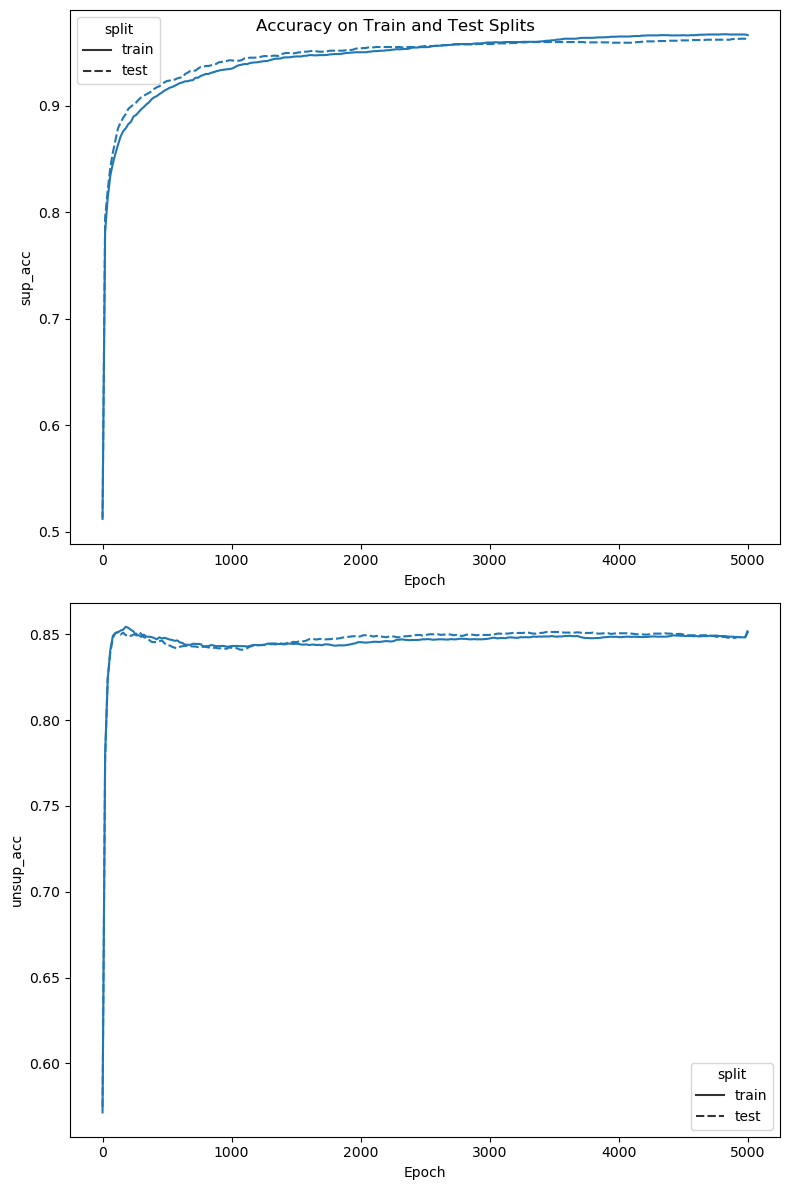

Round 1


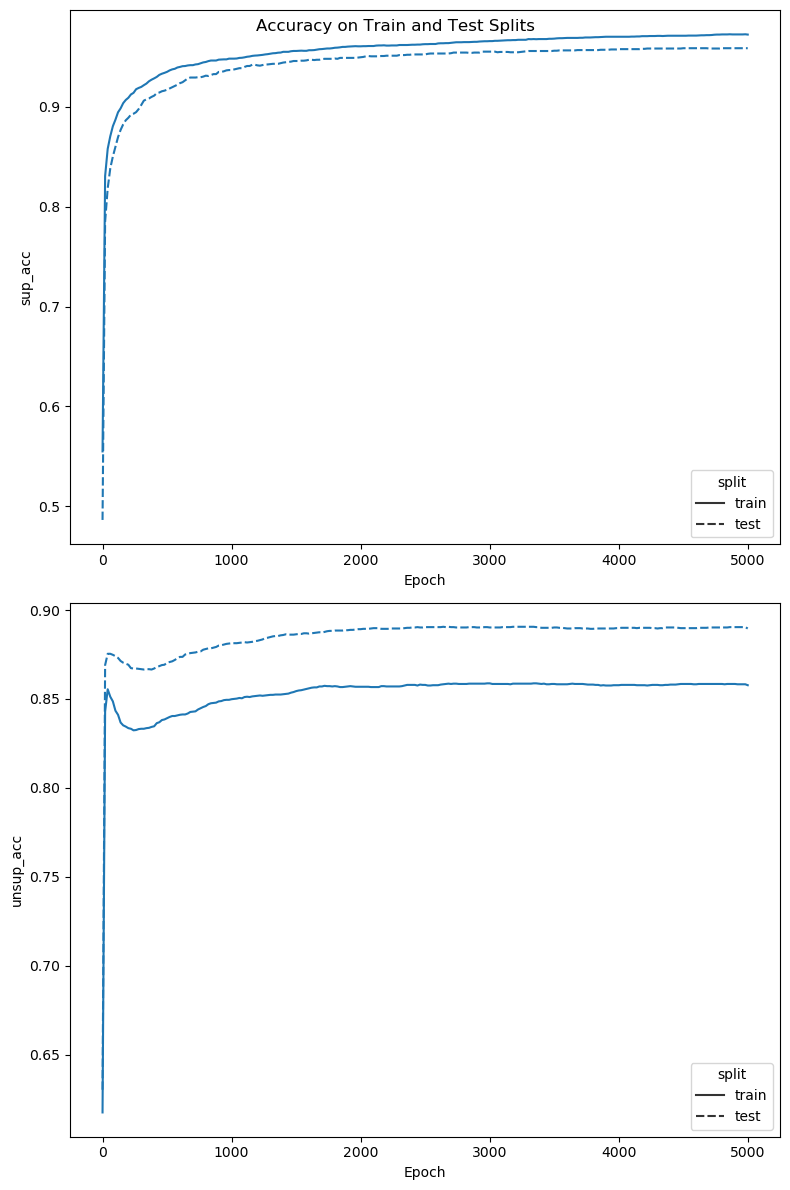

Round 2


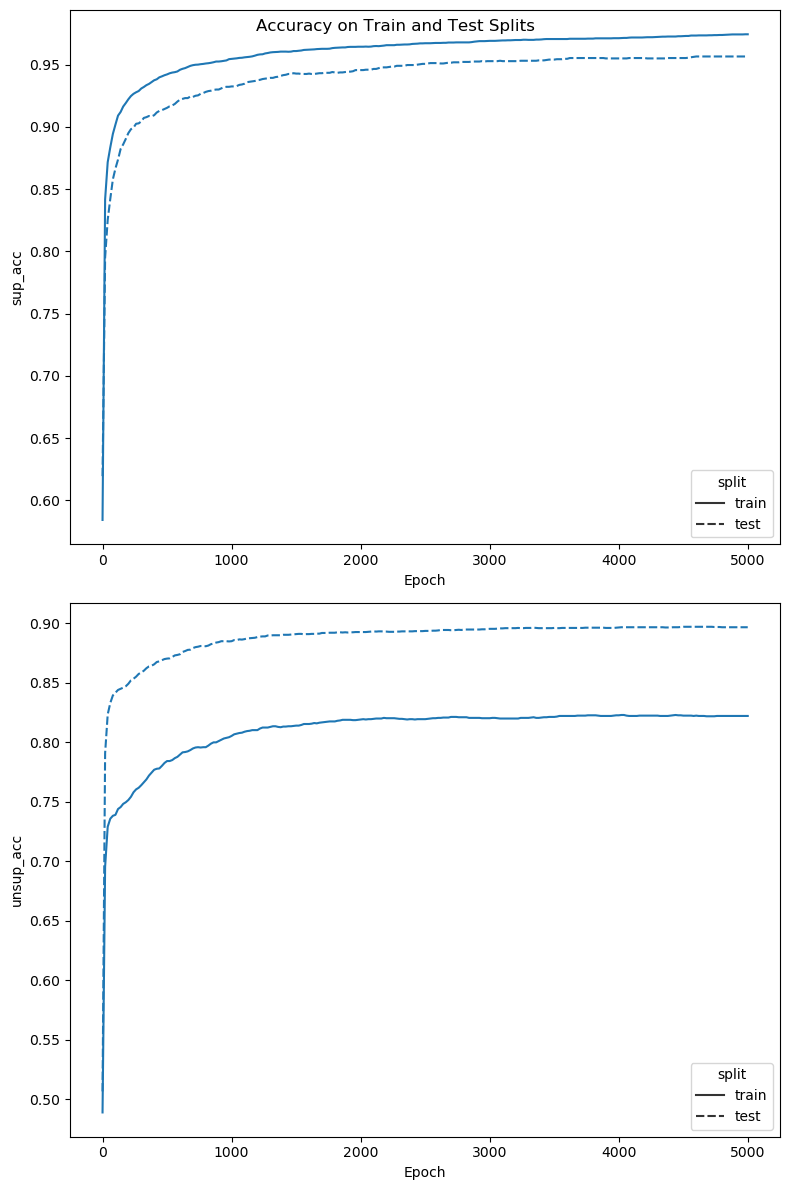

Round 3


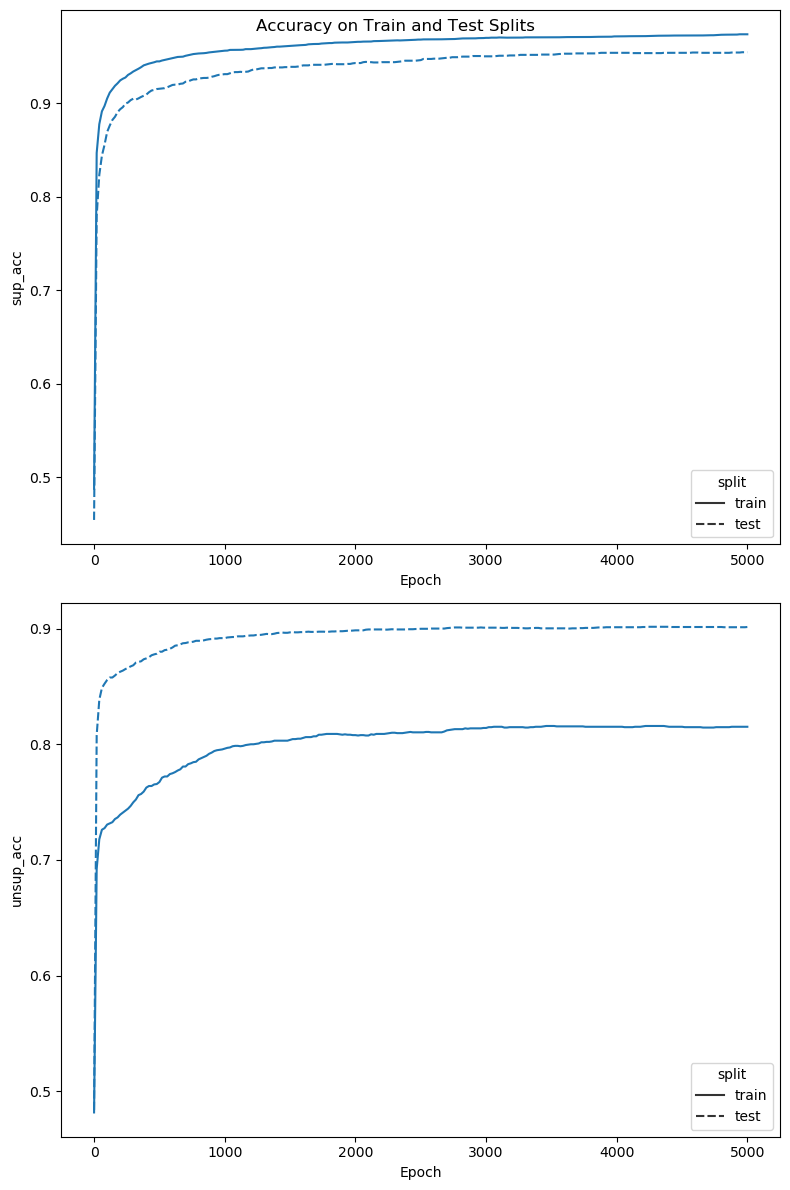

Round 4


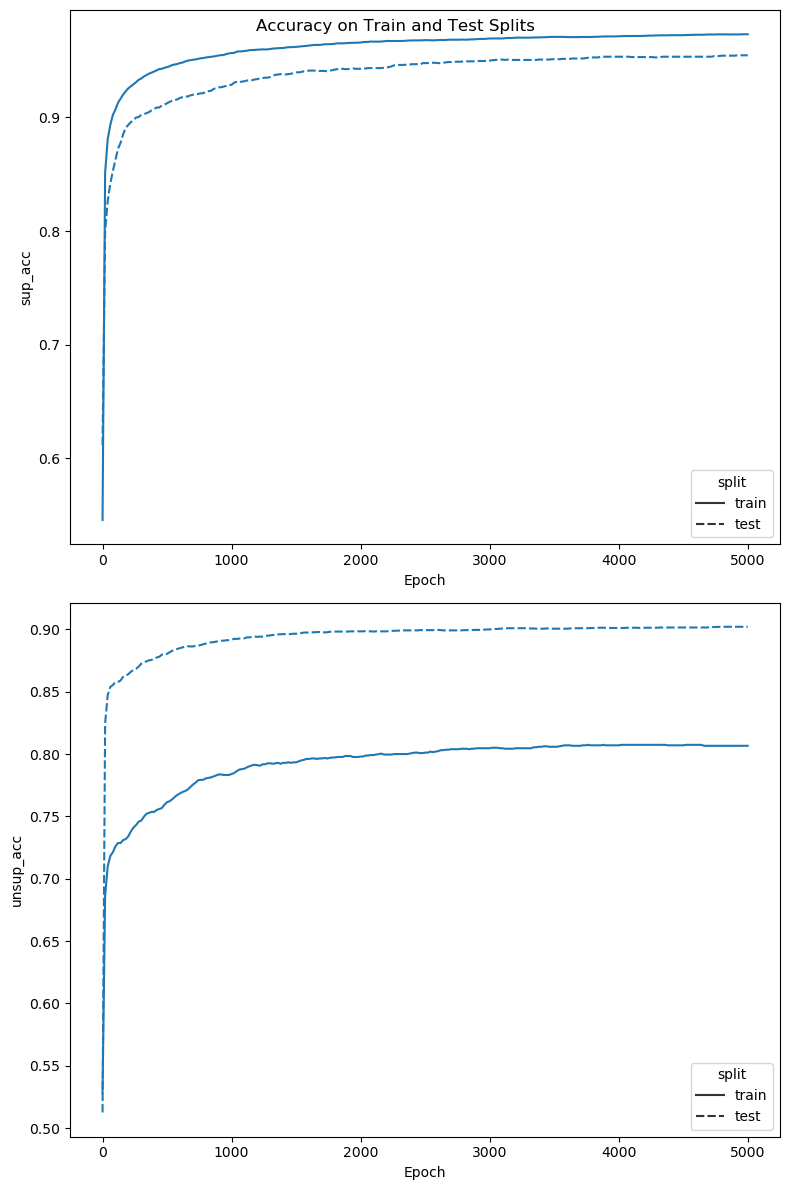

Round 5


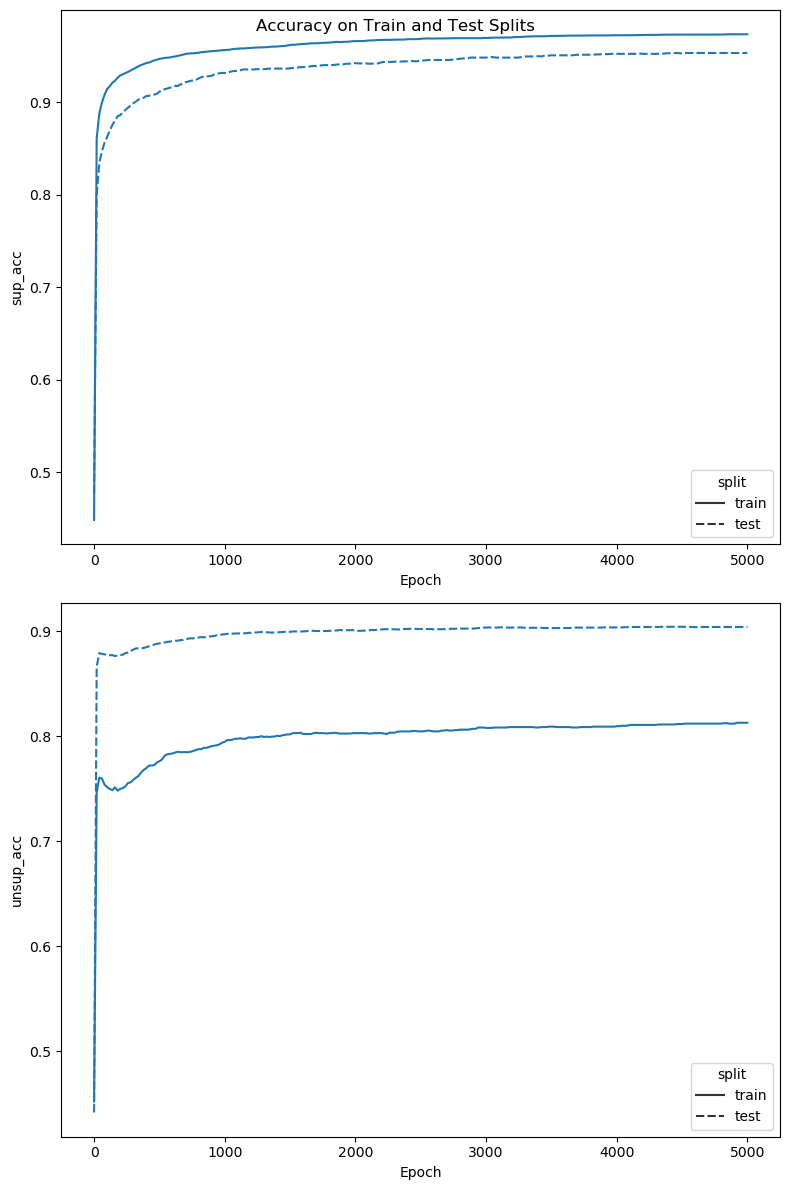

In [120]:
for i, fit_result in enumerate(fit_results):
    print(f"Round {i}")
    plot_accuracy(fit_result)

## Loss history plots

Round 0


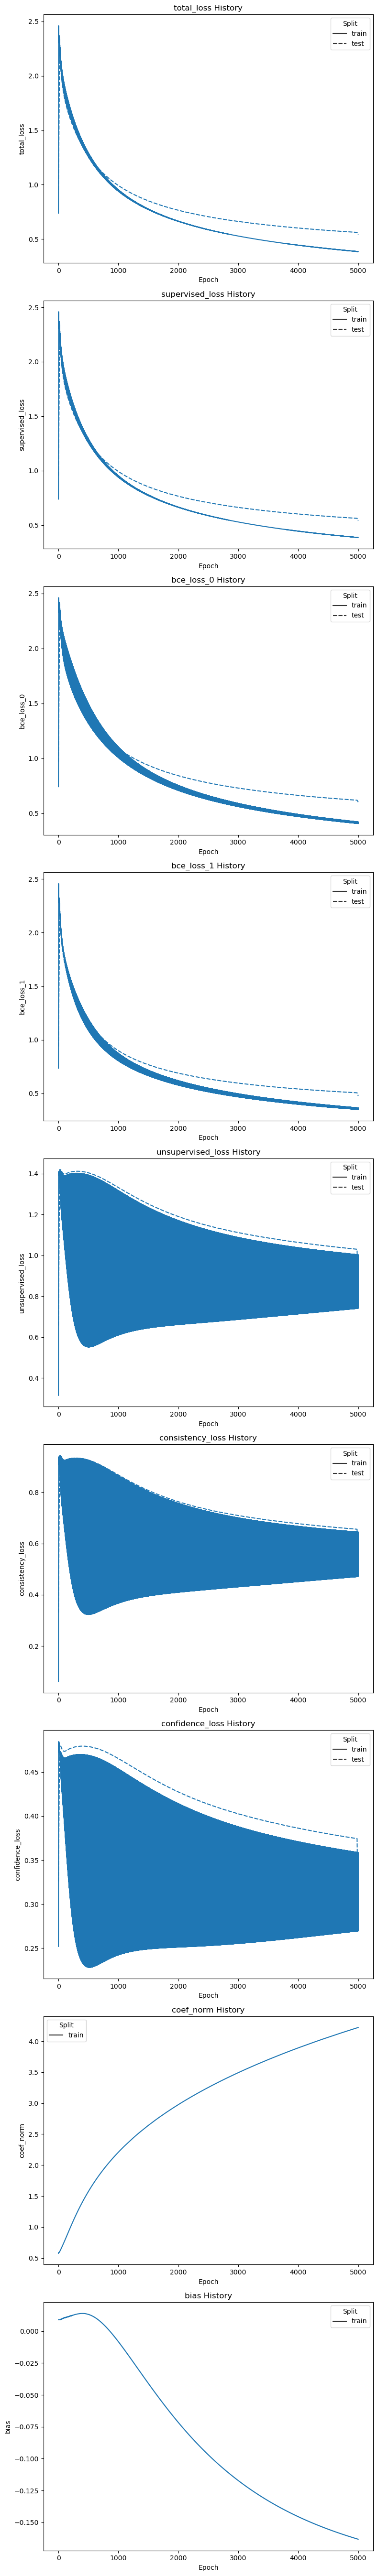

Round 1


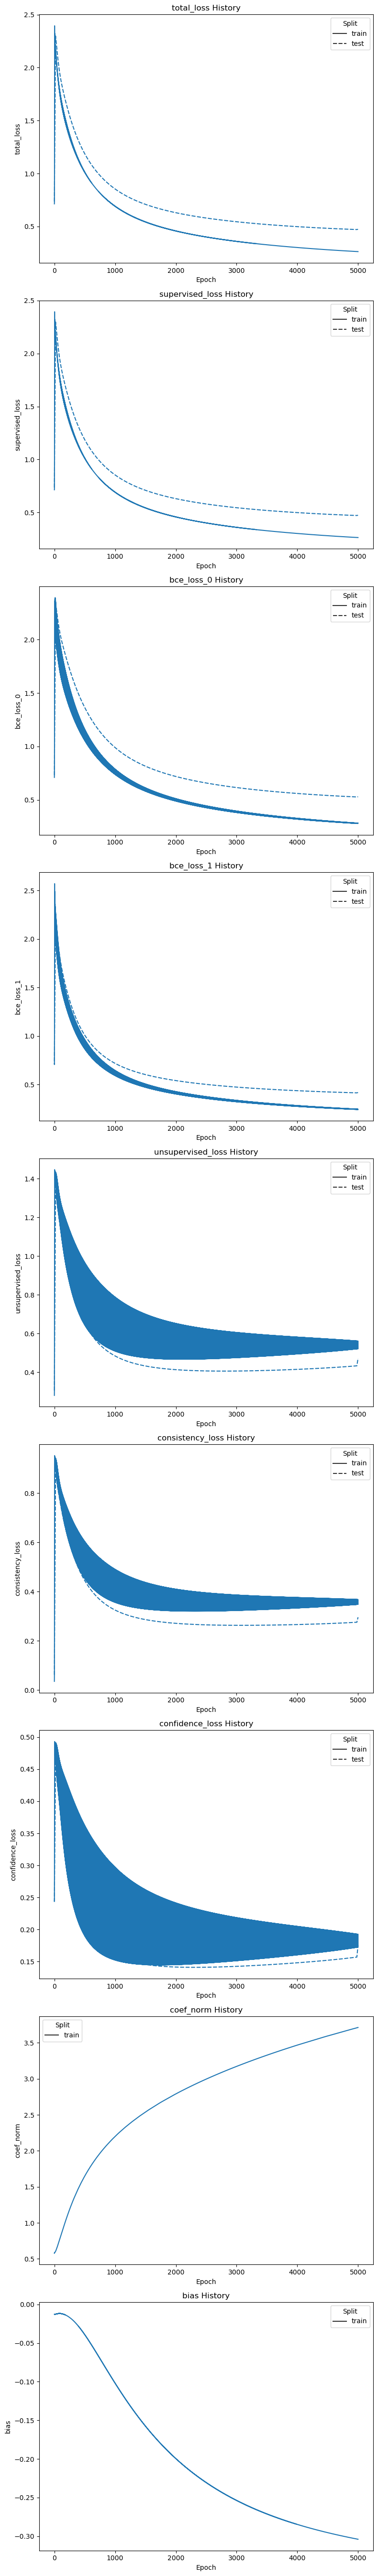

Round 2


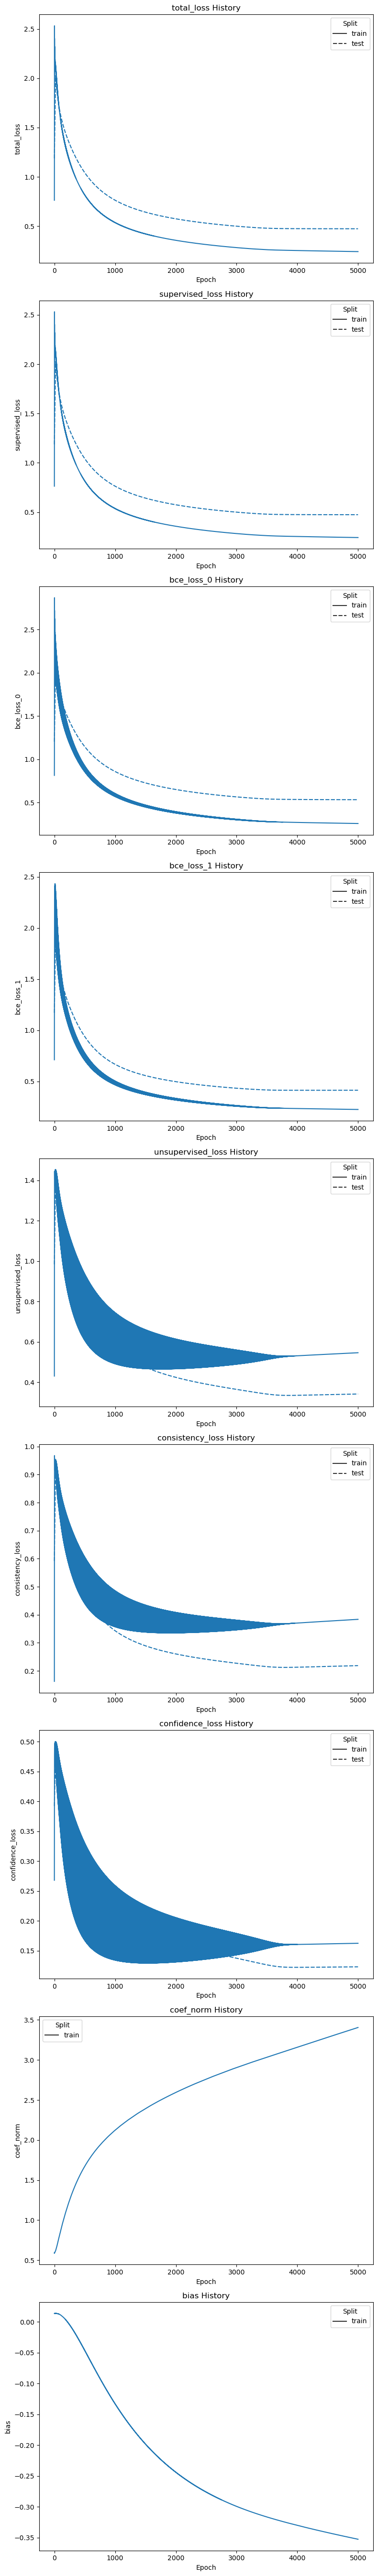

Round 3


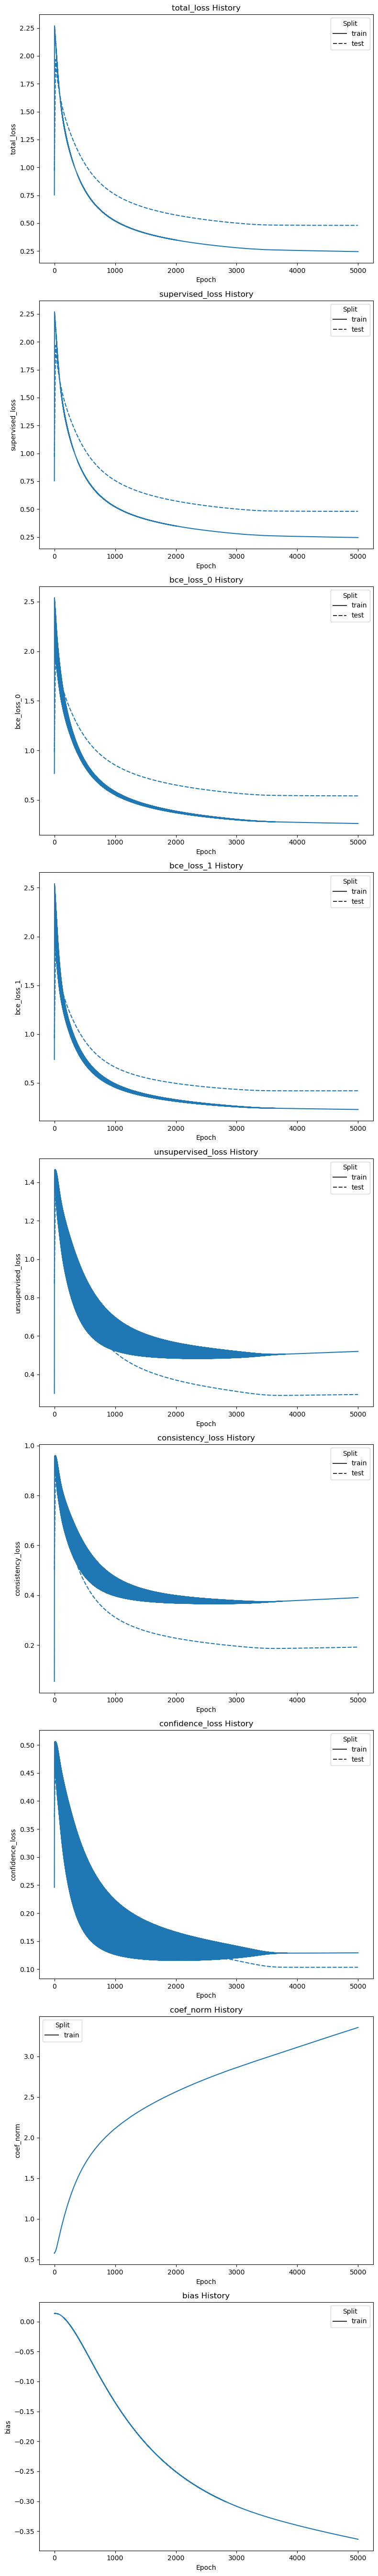

Round 4


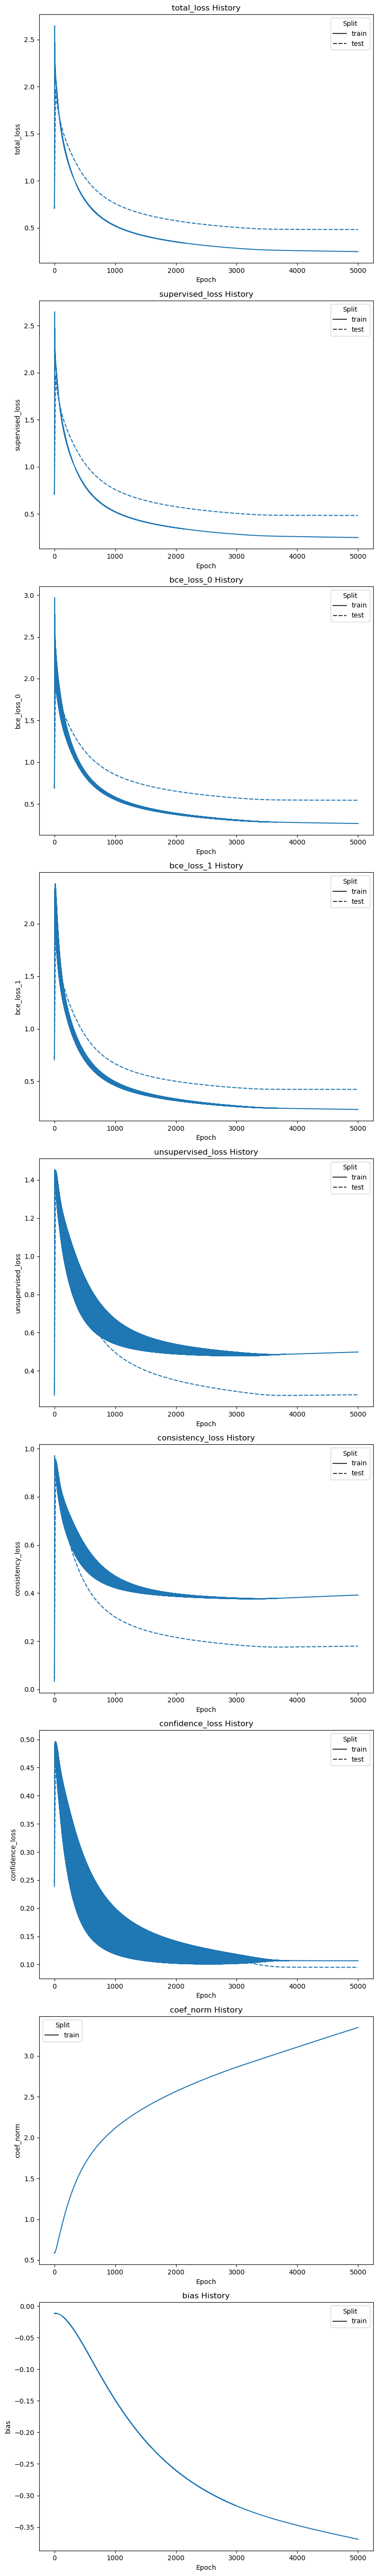

Round 5


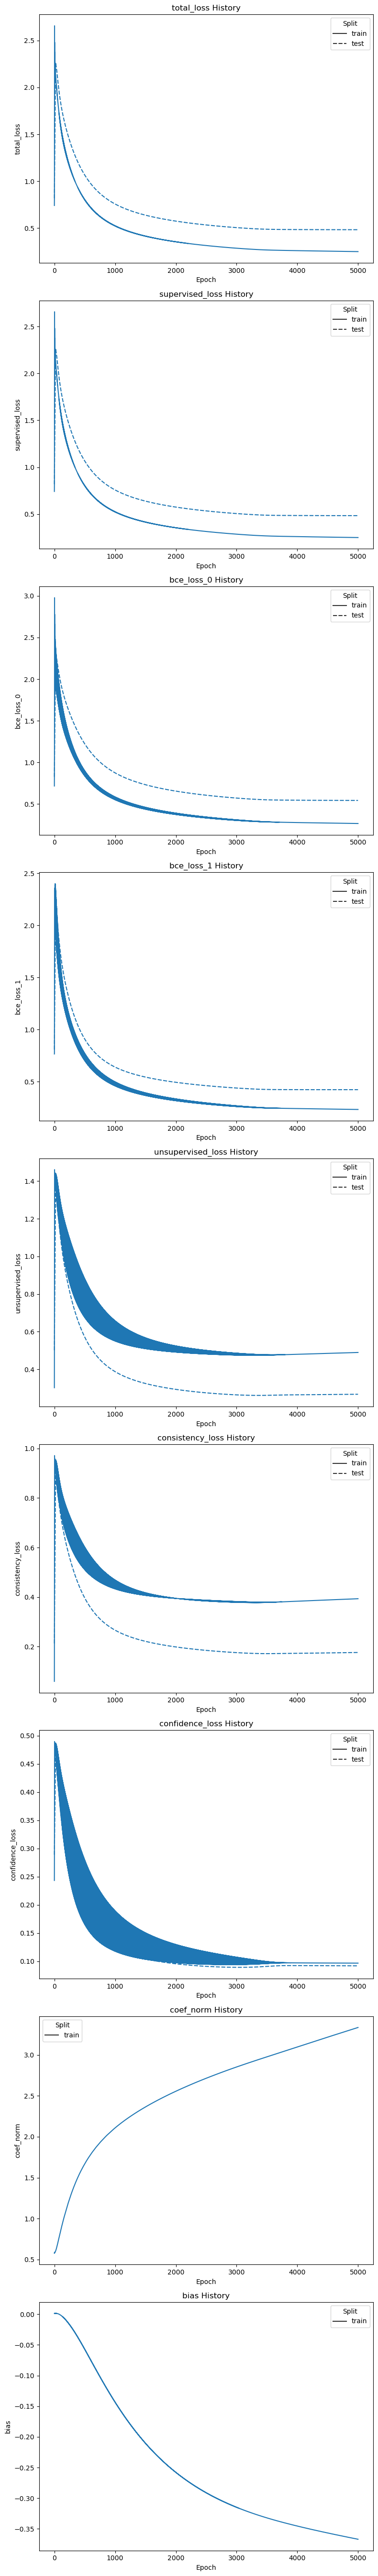

In [117]:
for i, fit_result in enumerate(fit_results):
    print(f"Round {i}")
    plot_history(fit_result)